In [6]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split


def load_object(path: str):
    try:
        image = Image.open(path)
        image = image.convert('L')
        image.resize((28, 28))
        return np.array(image).reshape(-1)
    except Exception as e:
        print(f"load_object exception: {e}")
        return None


TARGET_LABELS = ['target']
FEATURE_LABELS = ['path']
PIXEL_FEATURE_LABELS = []


def load_data(path: str):
    rows = []
    for dirname in os.listdir(path):
        dirpath = os.path.join(path, dirname)
        if not os.path.isdir(dirpath):
            continue

        objects = (
            {'target': dirname, 'data': load_object(os.path.join(dirpath, file)), 'path': os.path.join(dirpath, file)}
            for file in os.listdir(dirpath)
            if os.path.isfile(os.path.join(dirpath, file)) and os.path.getsize(os.path.join(dirpath, file)) > 0
        )
        rows.extend(objects)

    frame = pd.DataFrame(rows).dropna()
    flattened_data = np.stack(frame['data'].values)
    global PIXEL_FEATURE_LABELS
    PIXEL_FEATURE_LABELS = [f'data_pixel_{i}' for i in range(flattened_data.shape[1])]
    flattened_df = pd.DataFrame(flattened_data, columns=PIXEL_FEATURE_LABELS)
    result = pd.concat([frame[TARGET_LABELS + FEATURE_LABELS], flattened_df], axis=1)
    return result.dropna()


def split_data(data, train_size=0.6, val_size=0.2, test_size=0.2):
    assert train_size + val_size + test_size == 1, "The sum of train_size, val_size, and test_size must be 1"

    X_tv, X_test, y_tv, y_test = train_test_split(data[FEATURE_LABELS + PIXEL_FEATURE_LABELS], data[TARGET_LABELS], test_size=test_size, random_state=42)

    val_size_relative = val_size / (train_size + val_size)
    X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=val_size_relative, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Scikit-learn imports
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix,
    classification_report
)


def prepare_data(data):
    # Separate features and targets
    X = data[PIXEL_FEATURE_LABELS].values
    y = data[TARGET_LABELS].values.ravel()
    
    # Normalize pixel values
    X = X / 255.0
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)
    
    return X, y_categorical, label_encoder

def create_model(input_shape, num_classes, dropout_rate=0):
    model = Sequential([
        # Input layer
        Dense(256, activation='relu', input_shape=(input_shape,)),
        Dropout(dropout_rate),
        
        # Hidden layers
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    # Use Stochastic Gradient Descent (SGD) optimizer
    sgd = SGD(learning_rate=0.01, momentum=0.9, decay=1e-6)
    
    # Compile the model
    model.compile(
        optimizer=sgd,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


# Training with Callbacks
def train_model(model, X_train, y_train, X_val, y_val):
    early_stopping = EarlyStopping(
        monitor='val_loss',    # Metric to monitor
        patience=10,           # Epochs with no improvement
        restore_best_weights=True  # Restore best model weights
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    return history


# Visualization and Metrics
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def print_detailed_metrics(y_true, y_pred, label_encoder):
    # Overall Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("\n--- Prediction Metrics ---")
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Precision, Recall, F1-Score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    
    # Detailed Classification Report
    print("\n--- Detailed Classification Report ---")
    print(classification_report(
        y_true, 
        y_pred, 
        target_names=label_encoder.classes_
    ))
    
    # Confusion Matrix Visualization
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    # Per-class accuracy
    print("\n--- Per-Class Accuracy ---")
    class_accuracy = {}
    for label in label_encoder.classes_:
        label_indices = y_true == label
        class_acc = accuracy_score(y_true[label_indices], y_pred[label_indices])
        class_accuracy[label] = class_acc
        print(f"{label}: {class_acc:.4f}")
    
    return {
        'overall_accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'class_accuracy': class_accuracy
    }

# Evaluation Function
def evaluate_model(model, X_test, y_test, label_encoder):
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest accuracy: {test_accuracy:.4f}")
    print(f"Test loss: {test_loss:.4f}")
    
    # Predict 
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Inverse transform to get original labels
    y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
    y_true_labels = label_encoder.inverse_transform(y_true_classes)
    
    # Print detailed metrics
    metrics = print_detailed_metrics(y_true_classes, y_pred_classes, label_encoder)
    
    return y_pred_labels, y_true_labels, metrics

In [8]:

# Load the data
data = load_data('data/letters')

# Split the data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data)

# Prepare the data
X_train_processed, y_train_processed, label_encoder = prepare_data(
    pd.concat([X_train, y_train], axis=1)
)
X_val_processed, y_val_processed, _ = prepare_data(
    pd.concat([X_val, y_val], axis=1)
)
X_test_processed, y_test_processed, _ = prepare_data(
    pd.concat([X_test, y_test], axis=1)
)

In [9]:
# Get input shape and number of classes
input_shape = X_train_processed.shape[1]
num_classes = y_train_processed.shape[1]

# Create the model
model = create_model(input_shape, num_classes)

# Train the model
history = train_model(
    model,
    X_train_processed, y_train_processed, 
    X_val_processed, y_val_processed
)

Epoch 1/100
352/352 [==============================] - 1s 3ms/step - loss: 0.5903 - accuracy: 0.8262 - val_loss: 0.4092 - val_accuracy: 0.8734
Epoch 2/100
352/352 [==============================] - 1s 3ms/step - loss: 0.3361 - accuracy: 0.9016 - val_loss: 0.3524 - val_accuracy: 0.8887
Epoch 3/100
352/352 [==============================] - 1s 2ms/step - loss: 0.2793 - accuracy: 0.9164 - val_loss: 0.3436 - val_accuracy: 0.8897
Epoch 4/100
352/352 [==============================] - 1s 2ms/step - loss: 0.2359 - accuracy: 0.9294 - val_loss: 0.3502 - val_accuracy: 0.8927
Epoch 5/100
352/352 [==============================] - 1s 2ms/step - loss: 0.2003 - accuracy: 0.9383 - val_loss: 0.3302 - val_accuracy: 0.9049
Epoch 6/100
352/352 [==============================] - 1s 2ms/step - loss: 0.1707 - accuracy: 0.9472 - val_loss: 0.3551 - val_accuracy: 0.8975
Epoch 7/100
352/352 [==============================] - 1s 2ms/step - loss: 0.1452 - accuracy: 0.9552 - val_loss: 0.3324 - val_accuracy: 0.9025

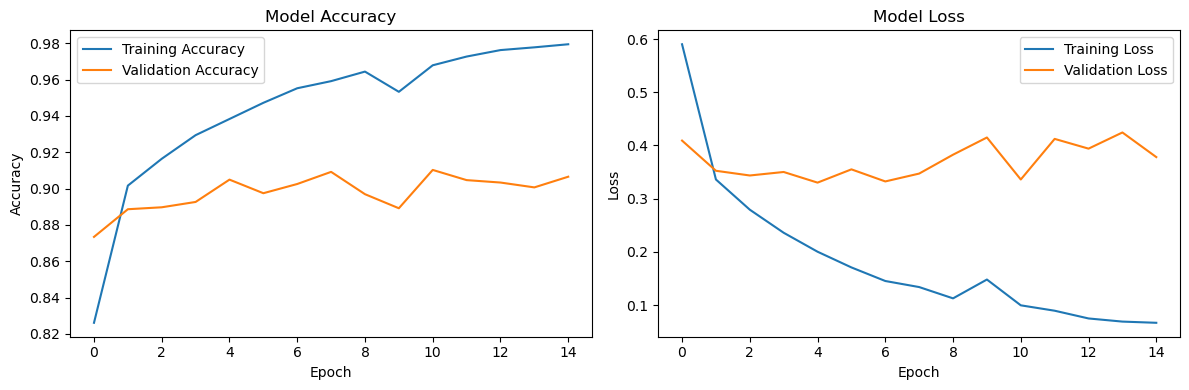


Test accuracy: 0.9170
Test loss: 0.2925
118/118 [==============================] - 0s 826us/step

--- Prediction Metrics ---
Overall Accuracy: 0.9170 (91.70%)
Weighted Precision: 0.9193
Weighted Recall: 0.9170
Weighted F1-Score: 0.9173

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           A       0.91      0.92      0.92       360
           B       0.85      0.92      0.88       373
           C       0.96      0.93      0.95       367
           D       0.90      0.94      0.92       370
           E       0.95      0.90      0.92       404
           F       0.96      0.93      0.94       357
           G       0.95      0.90      0.92       375
           H       0.95      0.91      0.93       380
           I       0.91      0.86      0.88       381
           J       0.84      0.96      0.90       378

    accuracy                           0.92      3745
   macro avg       0.92      0.92      0.92      3745
weighted avg       

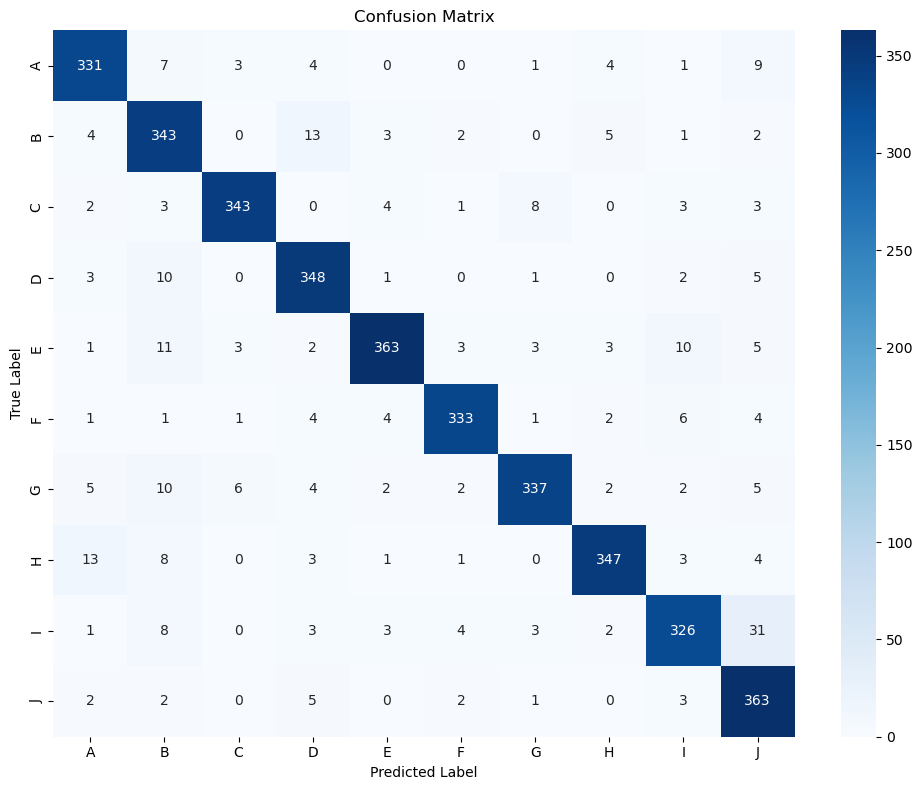


--- Per-Class Accuracy ---
A: nan
B: nan
C: nan
D: nan
E: nan
F: nan
G: nan
H: nan
I: nan
J: nan


d:\software\anaconda3\envs\ml\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
d:\software\anaconda3\envs\ml\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\software\anaconda3\envs\ml\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
d:\software\anaconda3\envs\ml\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\software\anaconda3\envs\ml\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
d:\software\anaconda3\envs\ml\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\software\anaconda3\env

In [10]:
# Plot training history
plot_training_history(history)

# Evaluate the model
metrics = evaluate_model(
    model, 
    X_test_processed,
    y_test_processed, 
    label_encoder
)


In [11]:
# Create the model
model = create_model(input_shape, num_classes, 0.3)

# Train the model
history = train_model(
    model,
    X_train_processed, y_train_processed, 
    X_val_processed, y_val_processed
)

Epoch 1/100
352/352 [==============================] - 1s 3ms/step - loss: 0.8768 - accuracy: 0.7208 - val_loss: 0.4561 - val_accuracy: 0.8611
Epoch 2/100
352/352 [==============================] - 1s 3ms/step - loss: 0.5033 - accuracy: 0.8555 - val_loss: 0.3890 - val_accuracy: 0.8766
Epoch 3/100
352/352 [==============================] - 1s 3ms/step - loss: 0.4349 - accuracy: 0.8763 - val_loss: 0.3720 - val_accuracy: 0.8836
Epoch 4/100
352/352 [==============================] - 1s 2ms/step - loss: 0.3846 - accuracy: 0.8885 - val_loss: 0.3617 - val_accuracy: 0.8857
Epoch 5/100
352/352 [==============================] - 1s 3ms/step - loss: 0.3806 - accuracy: 0.8870 - val_loss: 0.3528 - val_accuracy: 0.8929
Epoch 6/100
352/352 [==============================] - 1s 3ms/step - loss: 0.3522 - accuracy: 0.8965 - val_loss: 0.3315 - val_accuracy: 0.8991
Epoch 7/100
352/352 [==============================] - 1s 3ms/step - loss: 0.3296 - accuracy: 0.9020 - val_loss: 0.3336 - val_accuracy: 0.8985

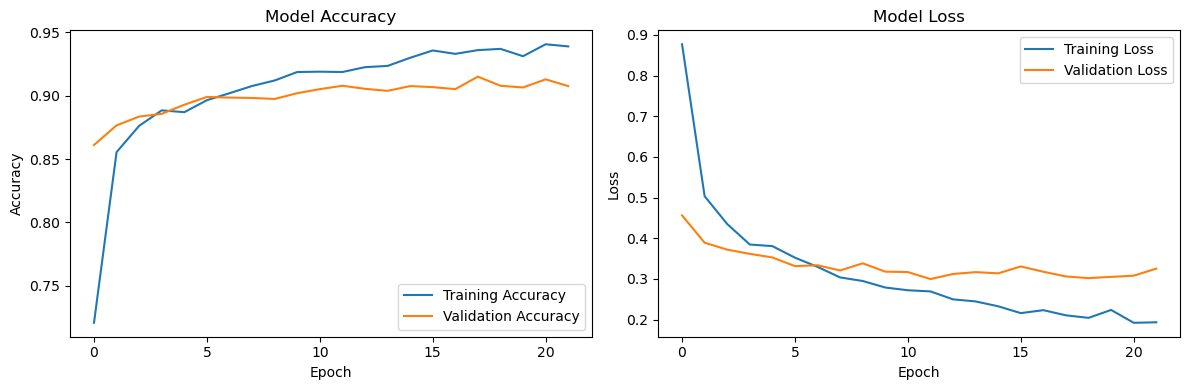


Test accuracy: 0.9215
Test loss: 0.2591
118/118 [==============================] - 0s 809us/step

--- Prediction Metrics ---
Overall Accuracy: 0.9215 (92.15%)
Weighted Precision: 0.9227
Weighted Recall: 0.9215
Weighted F1-Score: 0.9218

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           A       0.91      0.94      0.92       360
           B       0.93      0.88      0.91       373
           C       0.97      0.94      0.95       367
           D       0.93      0.93      0.93       370
           E       0.92      0.91      0.92       404
           F       0.95      0.94      0.94       357
           G       0.90      0.93      0.91       375
           H       0.96      0.91      0.93       380
           I       0.84      0.91      0.87       381
           J       0.93      0.93      0.93       378

    accuracy                           0.92      3745
   macro avg       0.92      0.92      0.92      3745
weighted avg       

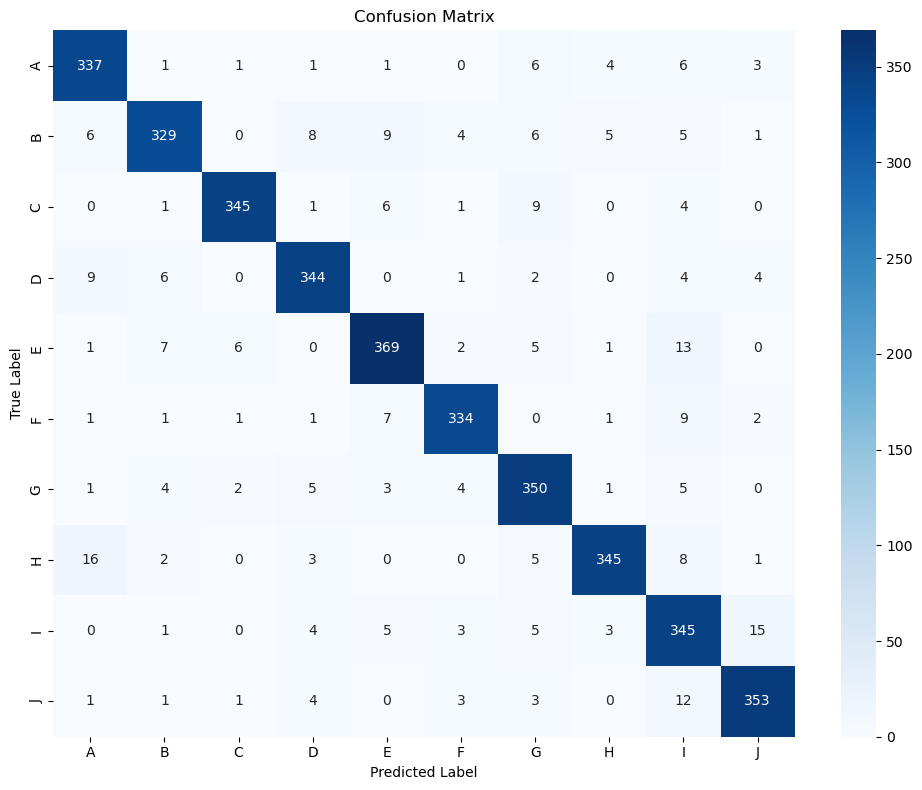


--- Per-Class Accuracy ---
A: nan
B: nan
C: nan
D: nan
E: nan
F: nan
G: nan
H: nan
I: nan
J: nan


d:\software\anaconda3\envs\ml\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
d:\software\anaconda3\envs\ml\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\software\anaconda3\envs\ml\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
d:\software\anaconda3\envs\ml\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\software\anaconda3\envs\ml\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
d:\software\anaconda3\envs\ml\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\software\anaconda3\env

In [12]:
# Plot training history
plot_training_history(history)

# Evaluate the model
metrics = evaluate_model(
    model, 
    X_test_processed,
    y_test_processed, 
    label_encoder
)

In [13]:
import tensorflow as tf

class AdaptiveLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr=0.001, patience=5):
        super().__init__()
        self.initial_lr = initial_lr
        self.patience = patience
        self.best_loss = np.inf
        self.wait = 0
    
    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        
        if current_loss is None:
            return
        
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.wait = 0
        else:
            self.wait += 1
            
            if self.wait >= self.patience:
                new_lr = self.initial_lr * (0.5 ** (self.wait // self.patience))
                print(f"\nReducing learning rate to {new_lr}")
                tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)
                self.wait = 0

def visualize_learning_rate_impact(history):
    plt.figure(figsize=(15, 5))
    
    # Accuracy Comparison
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label=f'Training')
    plt.plot(history.history['val_accuracy'], label=f'Validation')
    
    plt.title('Accuracy with Different LR Strategies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss Comparison
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f'Training')
    plt.plot(history.history['val_loss'], label=f'Validation')
    
    plt.title('Loss with Different LR Strategies')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def train_model_with_dynamic_lr(X_train, y_train, X_val, y_val):
    input_shape = X_train.shape[1]
    num_classes = y_train.shape[1]
    
    model = create_model(input_shape, num_classes)
    
    lr_schedules = [
        AdaptiveLearningRate(
            initial_lr=0.001, 
            patience=5
        )
    ]
    
    sgd = SGD(learning_rate=0.001, momentum=0.9, decay=1e-6)

    model.compile(
        optimizer=sgd,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=lr_schedules,
        verbose=1
    )
    
    return model, history


In [14]:
model, history = train_model_with_dynamic_lr(
    X_train_processed, y_train_processed, 
    X_val_processed, y_val_processed
)

Epoch 1/100
352/352 [==============================] - 1s 3ms/step - loss: 1.1153 - accuracy: 0.7133 - val_loss: 0.5642 - val_accuracy: 0.8494
Epoch 2/100
352/352 [==============================] - 1s 2ms/step - loss: 0.4935 - accuracy: 0.8691 - val_loss: 0.4613 - val_accuracy: 0.8686
Epoch 3/100
352/352 [==============================] - 1s 2ms/step - loss: 0.4298 - accuracy: 0.8823 - val_loss: 0.4327 - val_accuracy: 0.8758
Epoch 4/100
352/352 [==============================] - 1s 2ms/step - loss: 0.3942 - accuracy: 0.8930 - val_loss: 0.4108 - val_accuracy: 0.8846
Epoch 5/100
352/352 [==============================] - 1s 2ms/step - loss: 0.3715 - accuracy: 0.8988 - val_loss: 0.4028 - val_accuracy: 0.8870
Epoch 6/100
352/352 [==============================] - 1s 2ms/step - loss: 0.3531 - accuracy: 0.9034 - val_loss: 0.3962 - val_accuracy: 0.8849
Epoch 7/100
352/352 [==============================] - 1s 2ms/step - loss: 0.3353 - accuracy: 0.9080 - val_loss: 0.3764 - val_accuracy: 0.8862

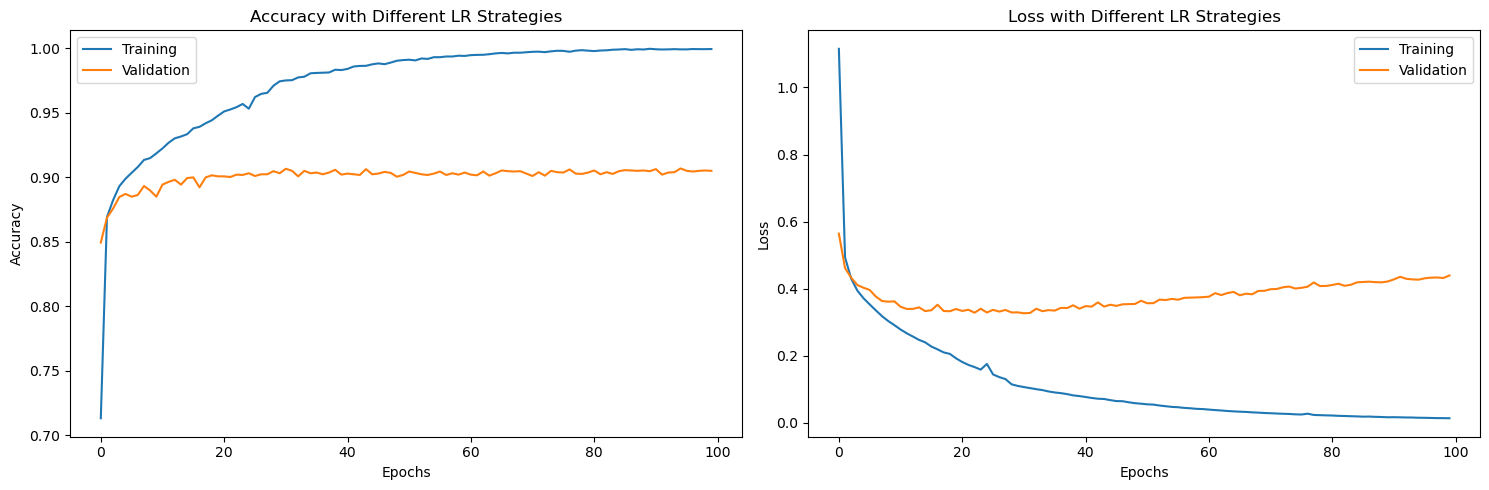

In [15]:
# Visualize results
visualize_learning_rate_impact(history)